Соревнование - курсовой "tutors-expected-math-exam-results"

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

Функции

In [2]:
def normalize(df, name):
    return (df[name] - df[name].min()) / (df[name].max() - df[name].min())

In [3]:
def distribution_chart(df, name):
    sns.distplot(df[name])
    plt.title(name)
    plt.show()

In [4]:
def show_correlations(df):
    plt.figure(figsize = (20,16))
    sns.set(font_scale=1.4)
    sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap='GnBu')
    plt.title('Корреляционная матрица')
    plt.show()

In [5]:
def show_correlation(df, name_one, name_two):
    print(np.cov(df[name_one], df[name_two]))
    grid = sns.jointplot(df[name_one], X_train_norm[name_two], kind='kde')
    grid.fig.set_figwidth(12)
    grid.fig.set_figheight(12)
    plt.show()

In [6]:
def show_nominative_signs(df):
    for colname in df.select_dtypes(include='object').columns:
        print(str(colname) + '\n\n' + str(df[colname].value_counts()) + '\n' + '*' * 100 + '\n')

In [7]:
def rebuild_nominative_signs(df, columns):
    for column in columns:
        df[column] = df[column].astype(str)
    show_nominative_signs(df)
    for column in df.select_dtypes(include='object').columns:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column, dtype=float)], axis=1)
    for column in columns:
        del df[column]
    return df

Случайный лес

In [8]:
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        for j in range(n_samples):
            sample_index = np.random.randint(1, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
    return bootstrap

In [9]:
def get_subsample(len_sample):
    sample_indexes = [i for i in range(len_sample)]
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    np.random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
    return subsample

In [10]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

In [11]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        return np.mean(self.labels)

In [12]:
def variance(values):
    return np.array(values).var()

In [13]:
def quality(left_labels, right_labels, current_variance):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_variance - p * variance(left_labels) - (1 - p) * variance(right_labels)

In [14]:
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [15]:
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_variance = variance(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_variance)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [16]:
def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [17]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [18]:
def classify_object(obj, node):
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [19]:
def gb_predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [20]:
def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(gb_predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

__Описание датасета__

| Наименование поля | Индекс | Описание |
|---|:---:|:---|
| Id  | 0 | идентификатор |
| age | 1 | возраст |
| years_of_experience | 2 | опыт работы |
| lesson_price | 3 | цена |
| qualification | 4 | квалификация |
| physics | 5 | ведет физику |
| chemistry | 6 | ведет химию |
| biology | 7 | ведет биологию |
| english | 8 | ведет английский |
| geography | 9 | ведет географию |
| history | 10 | ведет историю |
| mean_exam_points | 11 | средний балл за ЕГЭ |

Загрузка

In [21]:
df_train = pd.read_csv('data/tutors-expected-math-exam-results/train.csv', sep=',',header=0)

In [22]:
df_train.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


Смотрим свойства датасета

In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


Пропусков нет

Проведем обзор номинативных признаков. Перестроим номинативные признаки в бинарные классификационные признаки.

In [24]:
df_train = rebuild_nominative_signs(df_train, ['years_of_experience', 'qualification'])

years_of_experience

0.0     2785
2.0     1804
1.0     1757
3.0     1572
4.0     1122
5.0      584
6.0      282
7.0       70
8.0       20
9.0        3
10.0       1
Name: years_of_experience, dtype: int64
****************************************************************************************************

qualification

1.0    4884
2.0    3087
3.0    1979
4.0      50
Name: qualification, dtype: int64
****************************************************************************************************



In [25]:
df_train.head()

,Id,age,lesson_price,physics,chemistry,biology,english,geography,history,mean_exam_points,...,years_of_experience_4.0,years_of_experience_5.0,years_of_experience_6.0,years_of_experience_7.0,years_of_experience_8.0,years_of_experience_9.0,qualification_1.0,qualification_2.0,qualification_3.0,qualification_4.0
0,0,40.0,1400.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,48.0,2850.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,39.0,1200.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,46.0,1400.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,43.0,1500.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Посмотрим целевую переменную.

In [26]:
df_train['mean_exam_points'].value_counts()

65.0     338
58.0     326
63.0     324
67.0     317
61.0     316
        ... 
98.0       4
32.0       2
99.0       1
100.0      1
33.0       1
Name: mean_exam_points, Length: 69, dtype: int64

In [27]:
target_variable = df_train['mean_exam_points'].values

Удалим столбцы ненужные в обучении.

In [28]:
del df_train['Id']
del df_train['mean_exam_points']

Смотрим статистику

In [29]:
df_train.describe()

,age,lesson_price,physics,chemistry,biology,english,geography,history,years_of_experience_0.0,years_of_experience_1.0,...,years_of_experience_4.0,years_of_experience_5.0,years_of_experience_6.0,years_of_experience_7.0,years_of_experience_8.0,years_of_experience_9.0,qualification_1.0,qualification_2.0,qualification_3.0,qualification_4.0
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000
mean,45.878000,1699.105000,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,0.278500,0.175700,...,0.112200,0.05840,0.028200,0.007000,0.002000,0.000300,0.48840,0.30870,0.197900,0.005000
std,8.043929,524.886654,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,0.448283,0.380584,...,0.315628,0.23451,0.165552,0.083377,0.044679,0.017319,0.49989,0.46198,0.398436,0.070537
min,23.000000,200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
25%,40.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
50%,46.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
75%,51.000000,2150.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.00000,1.00000,0.000000,0.000000
max,68.000000,3950.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000


Масштабируем следующие признаки:
- age
- lesson_price

Поскольку остальные поля находятся в диапазоне от 0 до 1, то нормализуем наш датасет.

In [30]:
X_train_norm = df_train.copy()

X_train_norm['age'] = normalize(df_train, 'age')
X_train_norm['lesson_price'] = normalize(df_train, 'lesson_price')

Проверим...

In [31]:
X_train_norm.describe()

,age,lesson_price,physics,chemistry,biology,english,geography,history,years_of_experience_0.0,years_of_experience_1.0,...,years_of_experience_4.0,years_of_experience_5.0,years_of_experience_6.0,years_of_experience_7.0,years_of_experience_8.0,years_of_experience_9.0,qualification_1.0,qualification_2.0,qualification_3.0,qualification_4.0
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000
mean,0.508400,0.399761,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,0.278500,0.175700,...,0.112200,0.05840,0.028200,0.007000,0.002000,0.000300,0.48840,0.30870,0.197900,0.005000
std,0.178754,0.139970,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,0.448283,0.380584,...,0.315628,0.23451,0.165552,0.083377,0.044679,0.017319,0.49989,0.46198,0.398436,0.070537
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
25%,0.377778,0.293333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
50%,0.511111,0.346667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
75%,0.622222,0.520000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.00000,1.00000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000


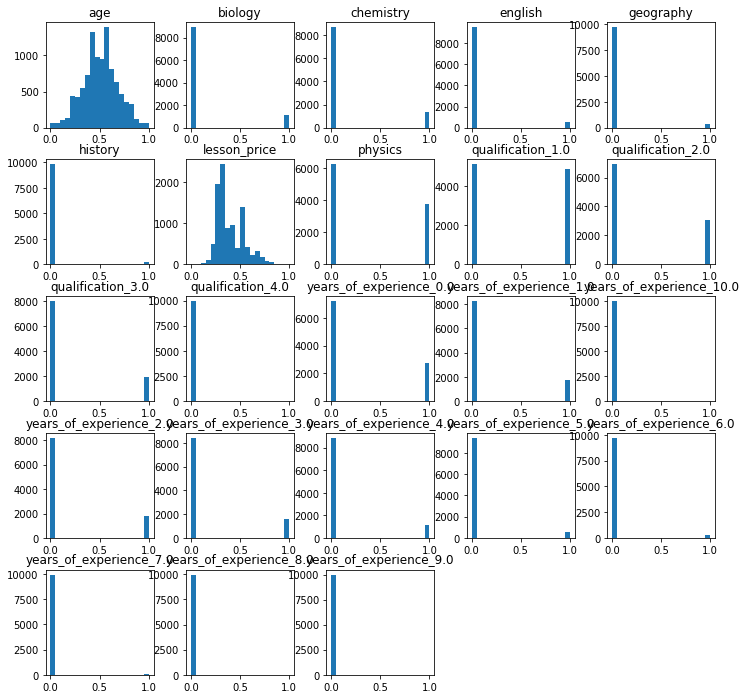

In [32]:
X_train_norm.hist(figsize=(12,12), bins=20, grid=False);

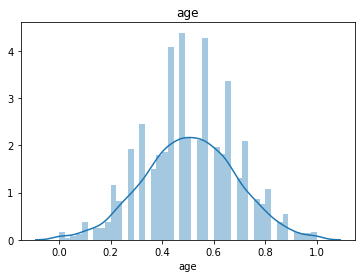

In [33]:
distribution_chart(X_train_norm, 'age')

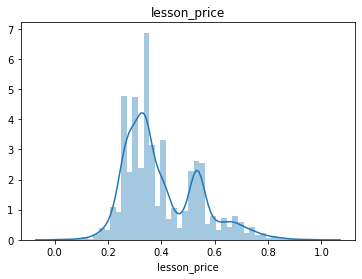

In [34]:
distribution_chart(X_train_norm, 'lesson_price')

Посмотрим корреляции....

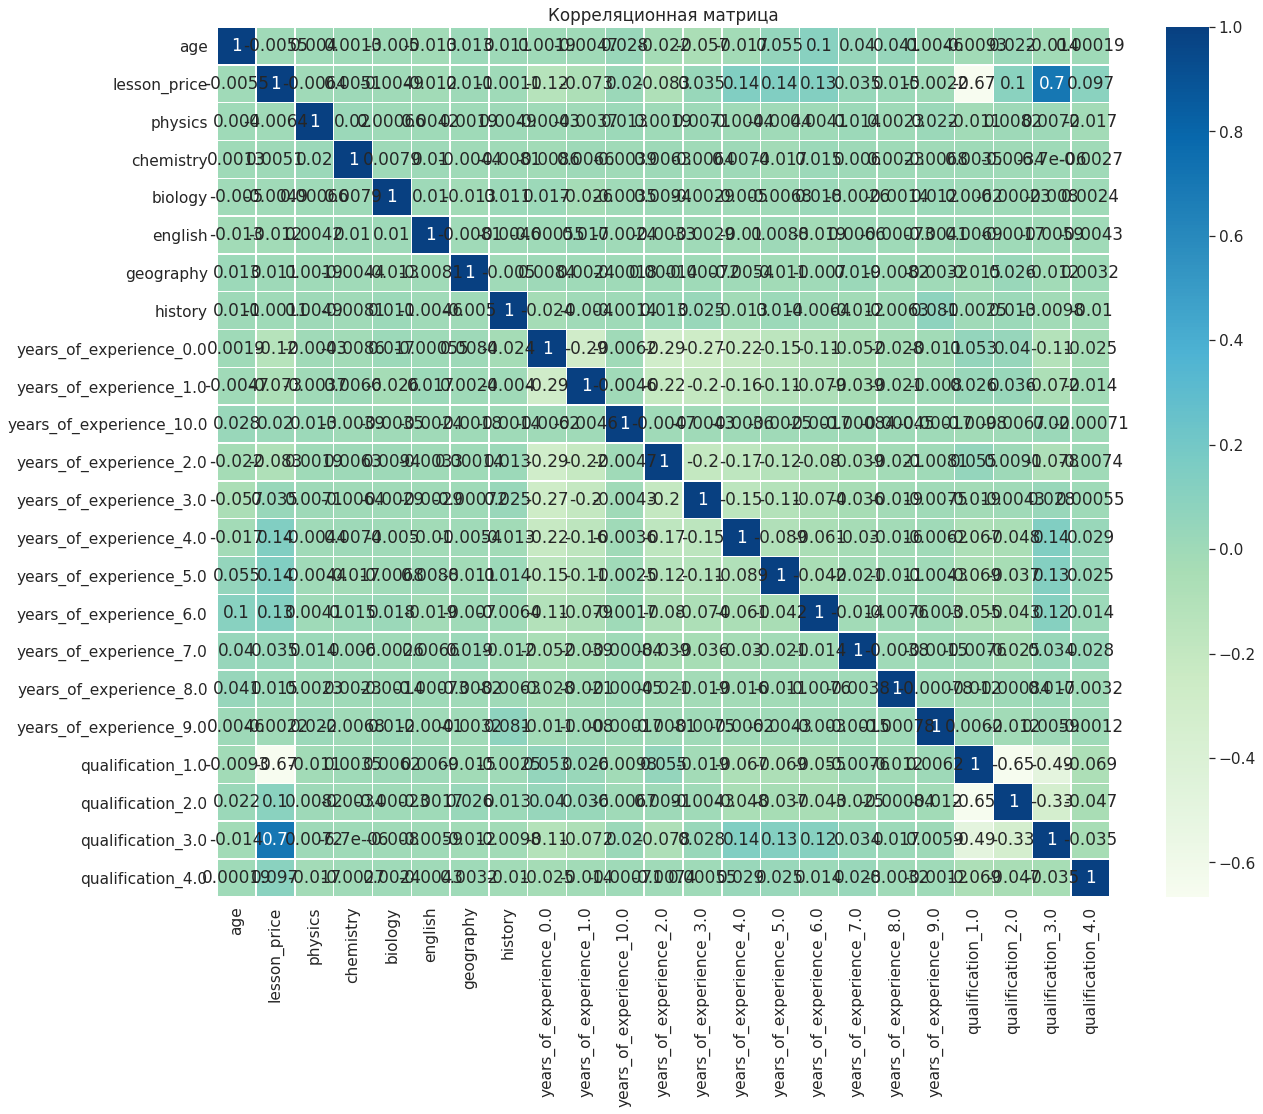

In [35]:
show_correlations(X_train_norm)

Видно, что баллы за ЕГЭ достаточно сильно коррелирует с ценой обучения и квалификацией преподавателя.

Разобъем датасет на Train и Тest

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_train_norm.values, 
                                                    target_variable, 
                                                    test_size=0.33, 
                                                    shuffle=True, 
                                                    random_state=21)

In [37]:
X_train_tr = X_train.transpose()
y_train_tr = y_train.reshape(1, y_train.shape[0])
X_test_tr = X_test.transpose()
y_test_tr = y_test.reshape(1, y_test.shape[0])

Решим с помощью случайного леса

In [38]:
n_trees = 200
forest = random_forest(X_train, y_train, n_trees)

In [39]:
train_answers = tree_vote(forest, X_train)
test_answers = tree_vote(forest, X_test)

In [40]:
train_accuracy = 100.0 - np.mean(np.abs(train_answers - y_train))
test_accuracy = 100.0 - np.mean(np.abs(test_answers - y_test))

print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Точность на обучающей выборке: 97.435
Точность на тестовой выборке: 93.954


Подготовим проверочные данные.

In [41]:
df_test = pd.read_csv('data/tutors-expected-math-exam-results/test.csv', sep=',',header=0)

In [42]:
df_test.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history
count,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000
mean,14999.50000,45.97280,1.980000,1697.095000,1.709400,0.38130,0.123500,0.120100,0.056000,0.031400,0.0184
std,2886.89568,7.95628,1.783289,524.262621,0.793483,0.48573,0.329027,0.325095,0.229933,0.174405,0.1344
min,10000.00000,23.00000,0.000000,200.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000
25%,12499.75000,41.00000,0.000000,1300.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000
50%,14999.50000,46.00000,2.000000,1500.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000
75%,17499.25000,51.00000,3.000000,2150.000000,2.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.0000
max,19999.00000,68.00000,10.000000,4050.000000,4.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.0000


In [43]:
df_test = rebuild_nominative_signs(df_test, ['years_of_experience', 'qualification'])

years_of_experience

0.0     2824
1.0     1798
2.0     1694
3.0     1593
4.0     1126
5.0      606
6.0      250
7.0       77
8.0       27
9.0        4
10.0       1
Name: years_of_experience, dtype: int64
****************************************************************************************************

qualification

1.0    4977
2.0    2998
3.0    1979
4.0      46
Name: qualification, dtype: int64
****************************************************************************************************



In [44]:
df_train.head()

,age,lesson_price,physics,chemistry,biology,english,geography,history,years_of_experience_0.0,years_of_experience_1.0,...,years_of_experience_4.0,years_of_experience_5.0,years_of_experience_6.0,years_of_experience_7.0,years_of_experience_8.0,years_of_experience_9.0,qualification_1.0,qualification_2.0,qualification_3.0,qualification_4.0
0,40.0,1400.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,48.0,2850.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,39.0,1200.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,46.0,1400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,43.0,1500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [45]:
X_test_norm = df_test.copy()

X_test_norm['age'] = normalize(df_test, 'age')
X_test_norm['lesson_price'] = normalize(df_test, 'lesson_price')

In [46]:
del X_test_norm['Id']

In [47]:
X_test_norm.describe()

,age,lesson_price,physics,chemistry,biology,english,geography,history,years_of_experience_0.0,years_of_experience_1.0,...,years_of_experience_4.0,years_of_experience_5.0,years_of_experience_6.0,years_of_experience_7.0,years_of_experience_8.0,years_of_experience_9.0,qualification_1.0,qualification_2.0,qualification_3.0,qualification_4.0
count,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.00000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,0.510507,0.388856,0.38130,0.123500,0.120100,0.056000,0.031400,0.0184,0.282400,0.17980,...,0.112600,0.060600,0.025000,0.007700,0.002700,0.000400,0.49770,0.299800,0.197900,0.004600
std,0.176806,0.136172,0.48573,0.329027,0.325095,0.229933,0.174405,0.1344,0.450189,0.38404,...,0.316119,0.238607,0.156133,0.087416,0.051894,0.019997,0.50002,0.458193,0.398436,0.067671
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.400000,0.285714,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,0.511111,0.337662,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,0.622222,0.506494,1.00000,0.000000,0.000000,0.000000,0.000000,0.0000,1.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [48]:
X_test_norm_tr = X_test_norm.transpose()

In [49]:
y_predicted_test_test = tree_vote(forest, X_test_norm.values)

In [50]:
df_res = pd.DataFrame({'Id':list(df_test['Id']),'mean_exam_points':y_predicted_test_test})

In [51]:
df_res.describe()

,Id,mean_exam_points
count,10000.00000,10000.000000
mean,14999.50000,63.910838
std,2886.89568,13.126801
min,10000.00000,34.000000
25%,12499.75000,54.615242
50%,14999.50000,61.247059
75%,17499.25000,72.000000
max,19999.00000,98.000000


In [52]:
df_res['mean_exam_points'].value_counts()

54.585366    326
61.000000    281
70.000000    239
59.277778    239
68.000000    223
            ... 
39.800000      1
84.533333      1
60.590909      1
73.857143      1
63.611111      1
Name: mean_exam_points, Length: 383, dtype: int64

In [53]:

df_res.to_csv('data/tutors-expected-math-exam-results/kruglikov.csv', index=False, encoding='utf-8')